In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

model_name1='k_fold_best_model_test'

In [3]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [4]:
k1=0
cantera_species=pd.read_csv(name_11+str(Ts[k1])+name_12+str(phis[k1])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k1])+name_22+str(phis[k1])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [5]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [6]:
n_models=4
all_scores=np.zeros((n_models,1+n_columns_mass_fraction))

In [7]:
for j in range(n_models):
    model_name=model_name1+str(j+1)
    Autoencoder = tf.keras.models.load_model(model_name, compile=False)
    results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()
   
    model_outputs=pd.DataFrame(results, columns=columns[1:2+n_columns_mass_fraction])
    
    from sklearn.metrics import mean_absolute_error
    for k in range(1+n_columns_mass_fraction):
        all_scores[j,k]=mean_absolute_error(dataset.iloc[:,k+1],model_outputs.iloc[:,k])

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt 

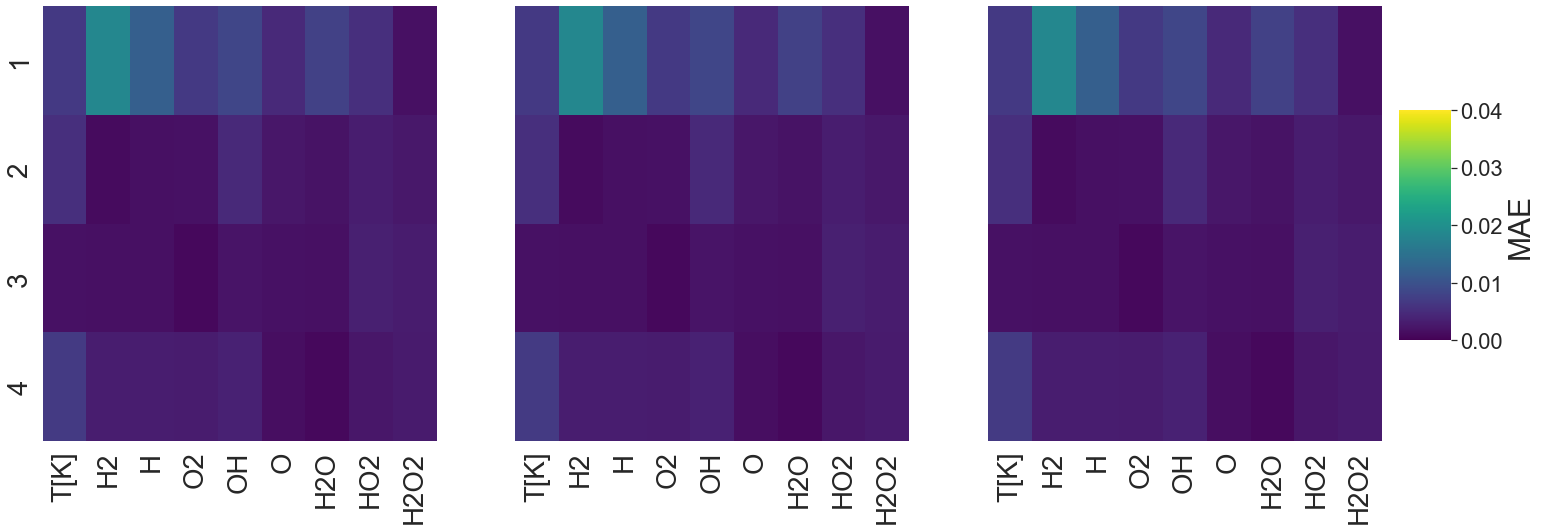

In [10]:
fig, axn = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(24,8))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i in range(len(phis)):
    cantera_species=pd.read_csv(name_11+str(Ts[i])+name_12+str(phis[i])+end)
    cantera_species=pd.DataFrame(cantera_species)

    cantera_sources=pd.read_csv(name_21+str(Ts[i])+name_22+str(phis[i])+end)
    cantera_sources=pd.DataFrame(cantera_sources)

    maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
    maximum_values=pd.DataFrame(maximum_values)
    
    dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)
    
    for j in range(n_models):
        model_name=model_name1+str(j+1)
        Autoencoder = tf.keras.models.load_model(model_name, compile=False)
        results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()
        
        model_outputs=pd.DataFrame(results, columns=columns[1:2+n_columns_mass_fraction])
        
        from sklearn.metrics import mean_absolute_error
        for k in range(1+n_columns_mass_fraction):
            all_scores[j,k]=mean_absolute_error(dataset.iloc[:,k+1],model_outputs.iloc[:,k])
        
        df = pd.DataFrame(all_scores, index=[1,2,3,4],columns=columns[1:2+n_columns_mass_fraction])
    
    
    for l, ax in enumerate(axn.flat):
        sns.set(font_scale=2.5)
        sns.heatmap(df, ax=ax,cmap="viridis",
                cbar=l == 0,
                vmin=0, vmax=0.04,
                cbar_ax=None if l else cbar_ax)
        plt.xticks(fontsize=22)
        plt.yticks(fontsize=22)
        plt.ylabel('MAE')
        
        #fig.tight_layout(rect=[0, 0, .9, 1])
    plt.savefig('time_series_TAE_MAE.jpg',dpi=400)